<a href="https://colab.research.google.com/github/dimidagd/gists/blob/main/nvidia_deeplearningexamples_hifigan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### This notebook requires a GPU runtime to run.
### Please select the menu option "Runtime" -> "Change runtime type", select "Hardware Accelerator" -> "GPU" and click "SAVE"

----------------------------------------------------------------------

# HiFi GAN

*Author: NVIDIA*

**The HiFi GAN model for generating waveforms from mel spectrograms**

<img src="https://pytorch.org/assets/images/hifigan_model.png" alt="alt" width="50%"/>



### Model Description
This notebook demonstrates a PyTorch implementation of the HiFi-GAN model described in the paper: [HiFi-GAN: Generative Adversarial Networks for Efficient and High Fidelity Speech Synthesis](https://arxiv.org/abs/2010.05646).
The HiFi-GAN model implements a spectrogram inversion model that allows to synthesize speech waveforms from mel-spectrograms. It follows the generative adversarial network (GAN) paradigm, and is composed of a generator and a discriminator. After training, the generator is used for synthesis, and the discriminator is discarded.

Our implementation is based on the one [published by the authors of the paper](https://github.com/jik876/hifi-gan). We modify the original hyperparameters and provide an alternative training recipe, which enables training on larger batches and faster convergence. HiFi-GAN is trained on a publicly available [LJ Speech dataset](https://keithito.com/LJ-Speech-Dataset/). The <a href="audio/">samples</a> demonstrate speech synthesized with our publicly available FastPitch and HiFi-GAN checkpoints.

#### Model architecture

![HiFiGAN Architecture](https://raw.githubusercontent.com/NVIDIA/DeepLearningExamples/master/PyTorch/SpeechSynthesis/HiFiGAN/img/hifigan_model.png)

### Example
In the example below:

- pretrained FastPitch and HiFiGAN models are loaded from torch.hub
- given tensor representation of an input text ("Say this smoothly to prove you are not a robot."), FastPitch generates mel spectrogram
- HiFiGAN generates sound given the mel spectrogram
- the output sound is saved in an 'audio.wav' file

To run the example you need some extra python packages installed. These are needed for preprocessing of text and audio, as well as for display and input/output handling. Finally, for better performance of FastPitch model, we download the CMU pronounciation dictionary.

In [ ]:
%%bash
pip install numpy scipy librosa unidecode inflect librosa matplotlib==3.6.3
apt-get update
apt-get install -y libsndfile1 wget
wget https://raw.githubusercontent.com/NVIDIA/NeMo/263a30be71e859cee330e5925332009da3e5efbc/scripts/tts_dataset_files/heteronyms-052722 -qO heteronyms
wget https://raw.githubusercontent.com/NVIDIA/NeMo/263a30be71e859cee330e5925332009da3e5efbc/scripts/tts_dataset_files/cmudict-0.7b_nv22.08 -qO cmudict-0.7b

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 74.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.5/235.5 kB 17.9 MB/s eta 0:00:00
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.7.1
    Uninstalling matplotlib-3.7.1:
      Successfully uninstalled matplotlib-3.7.1
Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Get:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Ign:4 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Hit:5 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [1,068 kB]
Get:7 https://r2u.stat.illinois.edu/ubuntu jammy Release [5,713 B]
Get:8 https://r2u.stat.illinois.edu/ubuntu jammy Release.gpg [793 B]
Get:9 http://archive.ubuntu.com/ubuntu jammy-updates InRele

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 1.22.0 requires matplotlib>=3.7.1, but you have matplotlib 3.6.3 which is incompatible.
plotnine 0.13.6 requires matplotlib>=3.7.0, but you have matplotlib 3.6.3 which is incompatible.
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)


In [ ]:
import torch
import matplotlib.pyplot as plt
from IPython.display import Audio
import warnings
warnings.filterwarnings('ignore')

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Using {device} for inference')

Using cuda for inference


Download and setup FastPitch generator model.

In [ ]:
fastpitch, generator_train_setup = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_fastpitch')

Downloading: "https://github.com/NVIDIA/DeepLearningExamples/zipball/torchhub" to /root/.cache/torch/hub/torchhub.zip


Download and setup vocoder and denoiser models.

In [ ]:
hifigan, vocoder_train_setup, denoiser = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_hifigan')

Using cache found in /root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub


HiFi-GAN: Removing weight norm.


Verify that generator and vocoder models agree on input parameters.

In [ ]:
CHECKPOINT_SPECIFIC_ARGS = [
    'sampling_rate', 'hop_length', 'win_length', 'p_arpabet', 'text_cleaners',
    'symbol_set', 'max_wav_value', 'prepend_space_to_text',
    'append_space_to_text']

for k in CHECKPOINT_SPECIFIC_ARGS:

    v1 = generator_train_setup.get(k, None)
    v2 = vocoder_train_setup.get(k, None)

    assert v1 is None or v2 is None or v1 == v2, \
        f'{k} mismatch in spectrogram generator and vocoder'

Put all models on available device.

In [ ]:
fastpitch.to(device)
hifigan.to(device)
denoiser.to(device)

Denoiser(
  (stft): STFT()
)

Load text processor.

In [ ]:
tp = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_textprocessing_utils', cmudict_path="cmudict-0.7b", heteronyms_path="heteronyms")

Using cache found in /root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub


Set the text to be synthetized, prepare input and set additional generation parameters.

In [ ]:
text = ["Artificial intelligence is transforming the world at an unprecedented pace. Every day, we see new advancements in fields like healthcare, education, and transportation, all driven by machine learning and automation."]
text += ["However, this rapid progress also raises important questions about ethics and the future of work."]

In [ ]:
batches = tp.prepare_input_sequence(text, batch_size=1)

{AA2 R T AH0 F IH1 SH AH0 L} {IH2 N T EH1 L AH0 JH AH0 N S} is {T R AE0 N S F AO1 R M IH0 NG} the {W ER1 L D} {AE1 T} an {AH0 N P R EH1 S IH0 D EH2 N T IH0 D} {P EY1 S}. every {D EY1}, {W IY1} {S IY1} new {AH0 D V AE1 N S M AH0 N T S} in {F IY1 L D Z} {L AY1 K} {HH EH1 L TH K EH2 R}, education, and {T R AE2 N S P ER0 T EY1 SH AH0 N}, {AO1 L} {D R IH1 V AH0 N} {B AY1} {M AH0 SH IY1 N} {L ER1 N IH0 NG} and {AO0 T AH0 M EY1 SH AH0 N}.
{HH AW2 EH1 V ER0}, this rapid progress {AO1 L S OW0} raises {IH2 M P AO1 R T AH0 N T} {K W EH1 S CH AH0 N Z} {AH0 B AW1 T} {EH1 TH IH0 K S} and the {F Y UW1 CH ER0} of {W ER1 K}.


In [ ]:
gen_kw = {'pace': 1.0,
          'speaker': 0,
          'pitch_tgt': None,
          'pitch_transform': None}
denoising_strength = 0.005

In [ ]:
import torch.nn.functional as F
scaling = 1
audio_segments = []
for batch in batches:
    with torch.no_grad():
        mel, mel_lens, *_ = fastpitch(batch['text'].to(device), **gen_kw)

        mel = F.interpolate(mel, size=(int(mel.shape[-1]*scaling)), mode='linear', align_corners=False)

        audios = hifigan(mel).float()
        audios = denoiser(audios.squeeze(1), denoising_strength)
        audios = audios.squeeze(1) * vocoder_train_setup['max_wav_value']
        audio_segments += [audios]

In [ ]:
len(batches)

1

Plot the intermediate spectorgram.

In [ ]:
audios = torch.cat(audio_segments,1)

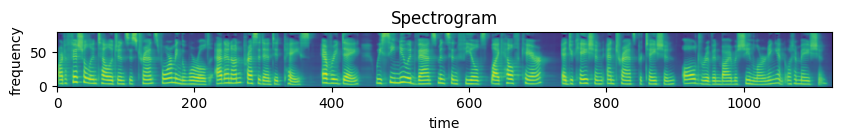

In [ ]:
plt.figure(figsize=(10,12))
res_mel = mel[0].detach().cpu().numpy()
plt.imshow(res_mel, origin='lower')
plt.xlabel('time')
plt.ylabel('frequency')
_=plt.title('Spectrogram')

Syntesize audio.

In [ ]:
audio_numpy = audios[0].cpu().numpy()
Audio(audio_numpy, rate=22050*scaling)

Write audio to wav file.

In [ ]:
from scipy.io.wavfile import write
write("audio.wav", vocoder_train_setup['sampling_rate'], audio_numpy)

### Details
For detailed information on model input and output, training recipies, inference and performance visit: [github](https://github.com/NVIDIA/DeepLearningExamples/tree/master/PyTorch/SpeechSynthesis/HiFiGAN) and/or [NGC](https://catalog.ngc.nvidia.com/orgs/nvidia/teams/dle/resources/hifigan_pyt)

### References

 - [HiFi-GAN: Generative Adversarial Networks for Efficient and High Fidelity Speech Synthesis](https://arxiv.org/abs/2010.05646)
 - [Original implementation](https://github.com/jik876/hifi-gan)
 - [FastPitch on NGC](https://catalog.ngc.nvidia.com/orgs/nvidia/teams/dle/resources/fastpitch_pyt)
 - [HiFi-GAN on NGC](https://catalog.ngc.nvidia.com/orgs/nvidia/teams/dle/resources/hifigan_pyt)
 - [FastPitch and HiFi-GAN on github](https://github.com/NVIDIA/DeepLearningExamples/tree/master/PyTorch/SpeechSynthesis/HiFi-GAN)